# Fake News Detection Using Natural Language Processing (NLP) and Classification Modeling

# Import Libraries

In [5]:
# API scrape 
from psaw import PushshiftAPI

# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


# Data Scrape

### API Scrape Function

In [6]:
def scrape_data(subreddit):
    
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit=subreddit,
                                filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=15000))

    #Filter list to only show Subreddit titles and Subreddit category 
    clean_scrape_lst = []
    for i in range(len(scrape_list)):
        scrape_dict = {}
        scrape_dict['subreddit'] = scrape_list[i][5]
        scrape_dict['author'] = scrape_list[i][0]
        scrape_dict['domain'] = scrape_list[i][2]
        scrape_dict['title'] = scrape_list[i][7]
        scrape_dict['num_comments'] = scrape_list[i][3]
        scrape_dict['score'] = scrape_list[i][4]
        scrape_dict['timestamp'] = scrape_list[i][1]
        clean_scrape_lst.append(scrape_dict)

    # Show number of subscribers
    print(subreddit, 'subscribers:',scrape_list[1][6])
    
    # Return list of scraped data
    return clean_scrape_lst

### Scrape r/nottheonion

In [7]:
# Call function and create DataFrame
df_not_onion = pd.DataFrame(scrape_data('nottheonion'))

# Save data to csv
df_not_onion.to_csv('./data/not_onion.csv')

# Shape of DataFrame
print(f'df_not_onion shape: {df_not_onion.shape}')

# Show head
df_not_onion.head()

nottheonion subscribers: 17083481
df_not_onion shape: (15000, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,nottheonion,TheBaikonurKing,afp.com,Vienna man fined 500 euros for deliberate 'mas...,0,1,1592361322
1,nottheonion,TheBaikonurKing,sg.news.yahoo.com,Vienna man fined 500 euros for deliberate 'mas...,1,1,1592361225
2,nottheonion,One_Day_Dead,polygon.com,Red Dead Online hackers can’t spawn the KKK an...,1,1,1592360910
3,nottheonion,hedonisticathiest,newsvoice.com,Austria: man fined for farting ’with full inte...,0,1,1592360879
4,nottheonion,conundrumbombs,thehill.com,Trump uses 'AIDS vaccine' as proof scientists ...,0,1,1592360368


### Scrape r/TheOnion

In [8]:
# Call function and create DataFrame
df_onion = pd.DataFrame(scrape_data('theonion'))

# Save data to csv
df_onion.to_csv('./data/the_onion.csv')

# Shape of DataFrame
print(f'df_onion shape: {df_onion.shape}')

# Show head
df_onion.head()

theonion subscribers: 149078
df_onion shape: (14978, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,TheOnion,deliberative22,theonion.com,NRA Receives Massive Funding Increase From Don...,4,157,1592318297
1,TheOnion,Sanlear,theonion.com,"‘So, It Means Making The Police Lose Their Hom...",2,1,1592276791
2,TheOnion,ThatsMyPhoenix,local.theonion.com,36-Year-Old Man Begins Outlining A Savings Pla...,6,1,1592259652
3,TheOnion,bwint1,local.theonion.com,City Enters Phase 4 Of Pretending Coronavirus ...,5,4,1592239238
4,TheOnion,hiddeninsite01,theonion.com,Online Activists Raise $5 Million To Create Ne...,3,1,1592227831


# Import Data

In [9]:
# If you're running this notebook, you can begin with this cell as the data has already been saved to a csv

# r/TheOnion DataFrame
df_onion = pd.read_csv('./data/the_onion.csv')

# r/nottheonion DataFrame
df_not_onion = pd.read_csv('./data/not_onion.csv')

### Preview `df_onion`

In [10]:
# Show first 5 rows of df_onion
print("Shape:", df_onion.shape)
df_onion.head()

Shape: (14978, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,TheOnion,deliberative22,theonion.com,NRA Receives Massive Funding Increase From Don...,4,157,1592318297
1,1,TheOnion,Sanlear,theonion.com,"‘So, It Means Making The Police Lose Their Hom...",2,1,1592276791
2,2,TheOnion,ThatsMyPhoenix,local.theonion.com,36-Year-Old Man Begins Outlining A Savings Pla...,6,1,1592259652
3,3,TheOnion,bwint1,local.theonion.com,City Enters Phase 4 Of Pretending Coronavirus ...,5,4,1592239238
4,4,TheOnion,hiddeninsite01,theonion.com,Online Activists Raise $5 Million To Create Ne...,3,1,1592227831


### Preview `df_not_onion`

In [11]:
# Show first 5 rows of df_not_onion
print("Shape:", df_not_onion.shape)
df_not_onion.head()

Shape: (15000, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,nottheonion,TheBaikonurKing,afp.com,Vienna man fined 500 euros for deliberate 'mas...,0,1,1592361322
1,1,nottheonion,TheBaikonurKing,sg.news.yahoo.com,Vienna man fined 500 euros for deliberate 'mas...,1,1,1592361225
2,2,nottheonion,One_Day_Dead,polygon.com,Red Dead Online hackers can’t spawn the KKK an...,1,1,1592360910
3,3,nottheonion,hedonisticathiest,newsvoice.com,Austria: man fined for farting ’with full inte...,0,1,1592360879
4,4,nottheonion,conundrumbombs,thehill.com,Trump uses 'AIDS vaccine' as proof scientists ...,0,1,1592360368


# Clean Data

### Data Cleaning Function

In [12]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

### Clean `df_onion`

In [13]:
# Call `clean_data(dataframe)` function
clean_data(df_onion)

New shape: (14007, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,TheOnion,deliberative22,theonion.com,nra receives massive funding increase from don...,4,157,1592318297
1,1,TheOnion,Sanlear,theonion.com,so it means making the police lose their home...,2,1,1592276791
2,2,TheOnion,ThatsMyPhoenix,local.theonion.com,year old man begins outlining a savings plan ...,6,1,1592259652
3,3,TheOnion,bwint1,local.theonion.com,city enters phase of pretending coronavirus over,5,4,1592239238
4,4,TheOnion,hiddeninsite01,theonion.com,online activists raise million to create new m...,3,1,1592227831


### Clean `df_not_onion`

In [14]:
# Call `clean_data(dataframe)` function
clean_data(df_not_onion)

New shape: (11672, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,nottheonion,TheBaikonurKing,afp.com,vienna man fined euros for deliberate massive...,0,1,1592361322
2,2,nottheonion,One_Day_Dead,polygon.com,red dead online hackers can t spawn the kkk an...,1,1,1592360910
3,3,nottheonion,hedonisticathiest,newsvoice.com,austria man fined for farting with full intent...,0,1,1592360879
4,4,nottheonion,conundrumbombs,thehill.com,trump uses aids vaccine as proof scientists ca...,0,1,1592360368
5,5,nottheonion,canuck_11,bbc.com,a judge who was said to have died of a heart a...,0,1,1592359998


### Check Nulls

In [15]:
# Create a DataFrame to check nulls
pd.DataFrame([df_onion.isnull().sum(),df_not_onion.isnull().sum()], index=["TheOnion","notheonion"]).T

,TheOnion,notheonion
Unnamed: 0,0,0
subreddit,0,0
author,0,0
domain,0,0
title,0,0
num_comments,0,0
score,0,0
timestamp,0,0


# Exploratory Data Analysis (EDA)

### Date Range of Scraped Posts

In [16]:
# Convert Unix Timestamp to Datetime
df_onion['timestamp'] = pd.to_datetime(df_onion['timestamp'], unit='s')
df_not_onion['timestamp'] = pd.to_datetime(df_not_onion['timestamp'], unit='s')

# Show date-range of posts scraped from r/TheOnion and r/nottheonion
print("TheOnion start date:", df_onion['timestamp'].min())
print("TheOnion end date:", df_onion['timestamp'].max())
print("nottheonion start date:", df_not_onion['timestamp'].min())
print("nottheonion end date:", df_not_onion['timestamp'].max())

TheOnion start date: 2016-07-27 22:47:35
TheOnion end date: 2020-06-16 14:38:17
nottheonion start date: 2020-04-04 04:30:21
nottheonion end date: 2020-06-17 02:35:22


### Bar Plot Function

In [17]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

### r/TheOnion: Most Active Authors

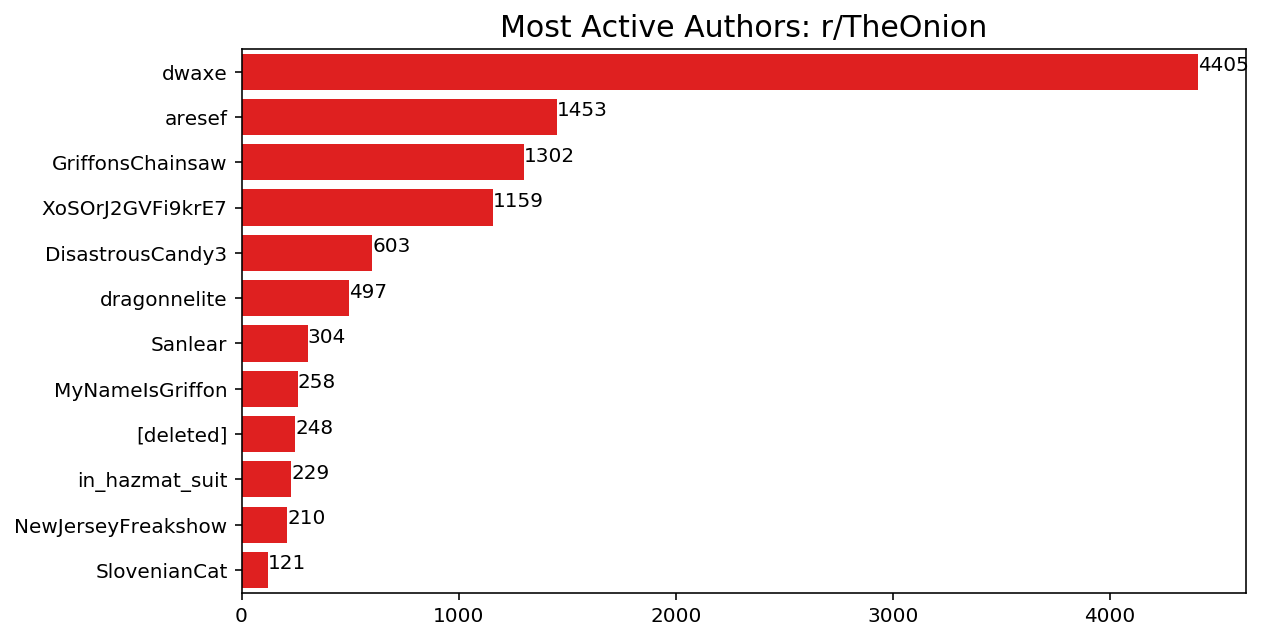

In [18]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values, df_onion_authors_index, 'Most Active Authors: r/TheOnion', 'r') 

r/TheOnion has only 95k subscribers, but 14 authors shared over 100 posts, the most being 4,113 posts.

### r/nottheonion: Most Active Authors

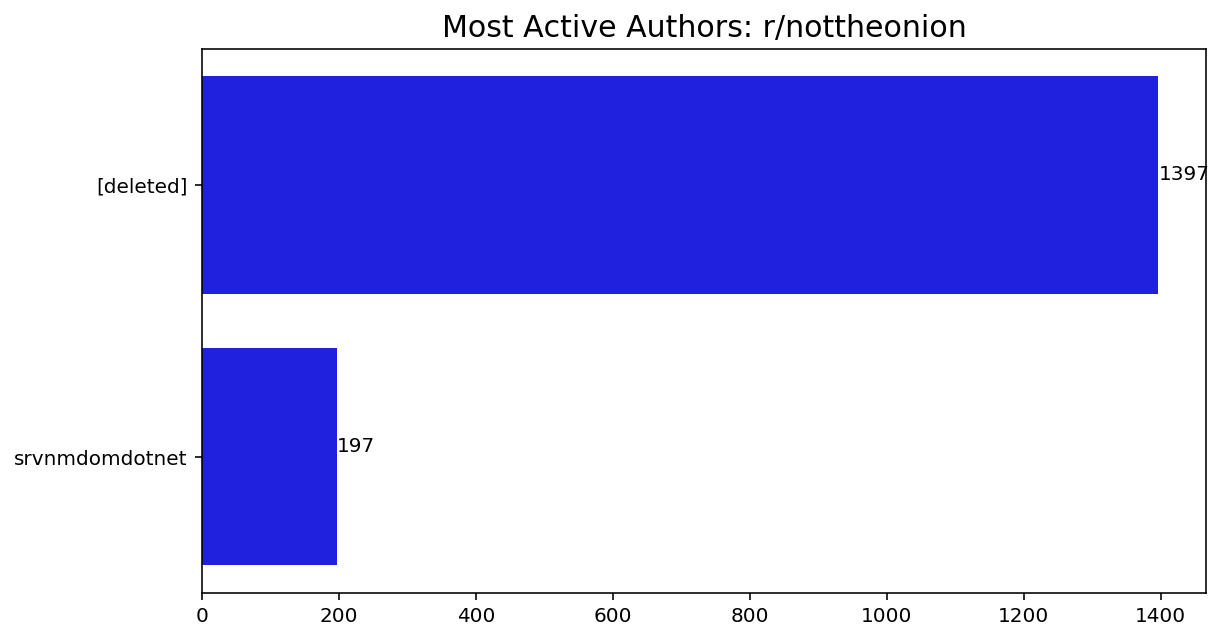

In [19]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts() 
df_not_onion_authors = df_not_onion_authors[df_not_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

# Call function
bar_plot(df_not_onion_authors.values, df_not_onion_authors_index, 'Most Active Authors: r/nottheonion','b') 

r/nottheonion has 15m subscribers, and only 3 authors shared over 100 posts.   

### r/TheOnion: Most Referenced Domains

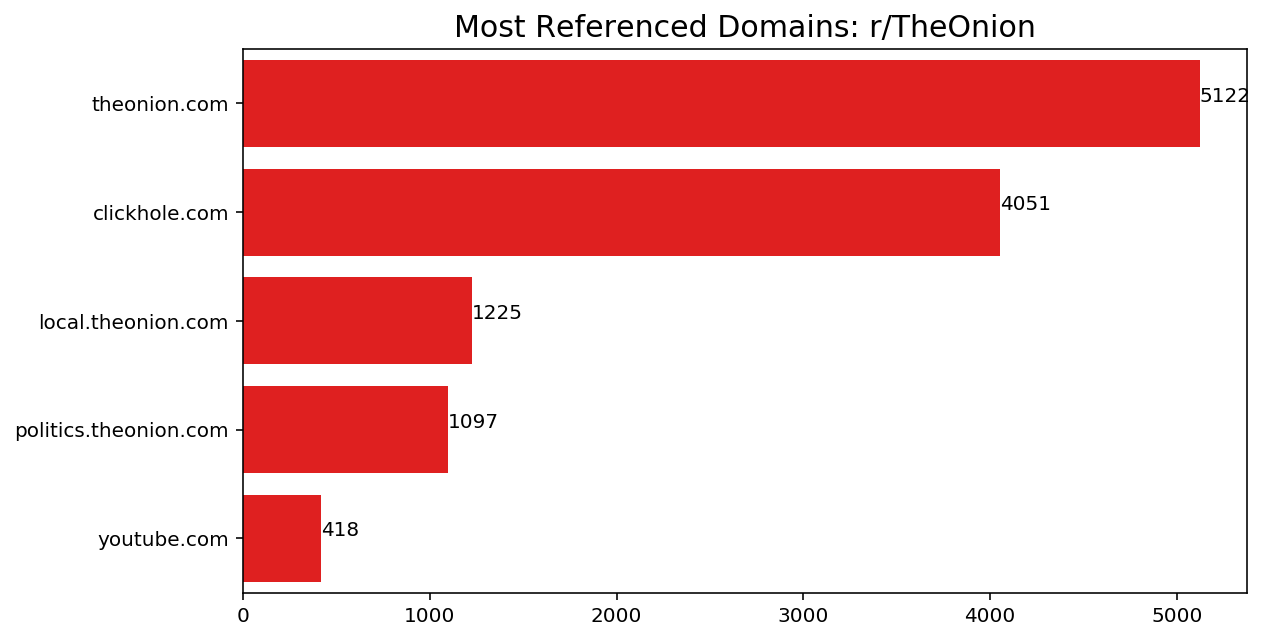

In [20]:
# Set x values: # of posts
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_onion_domain_index = list(df_onion_domain.index)
df_onion_domain_index
# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/TheOnion','r') 

Unsurprisingly, the most referenced domains from r/TheOnion are from The Onion. This subreddit allows articles from other news satire sites to be shared here as well.

### r/nottheonion: Most Referenced Domains

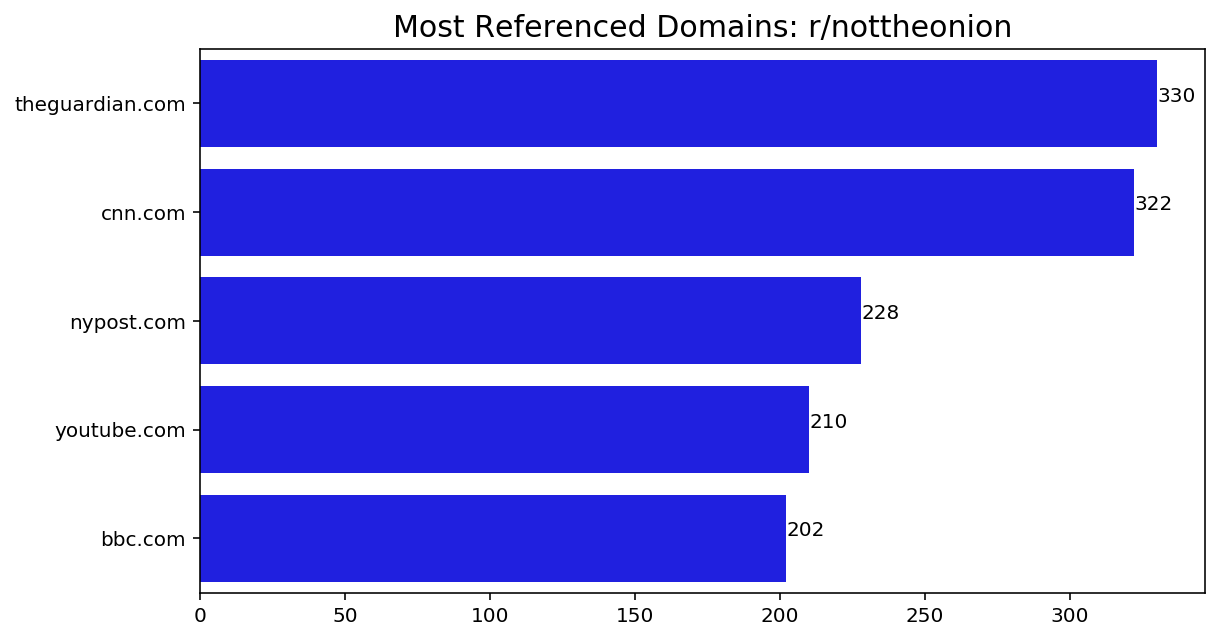

In [21]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','b') 

Also unsurprisingly, foxnews.com is the most referenced domain in r/nottheonion! 

# Natural Language Processing (NLP)

Here I use Count Vectorizer to continue my EDA and explore the most used words and combinations of words from each subreddit. 

### Concatenate DataFrames

In [22]:
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_not_onion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)

# Preview head of df to show 'TheOnion' titles appear
df.head(2)

,subreddit,title
0,TheOnion,nra receives massive funding increase from don...
1,TheOnion,so it means making the police lose their home...


In [23]:
# Preview head of df to show 'nottheonion' titles appear
df.tail(2)

,subreddit,title
25677,nottheonion,some states receive masks with dry rot broken ...
25678,nottheonion,georgia governor s executive order reopens sta...


### Binarize Target `subreddit`
 - `TheOnion`: 1
 - `nottheonion`: 0

In [24]:
# Replace `TheOnion` with 1, `nottheonion` with 0
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Print shape of df
print(df.shape)

# Preview head of df to show 1s
df.head(2)

(25679, 2)


,subreddit,title
0,1,nra receives massive funding increase from don...
1,1,so it means making the police lose their home...


In [25]:
# Preview tail of df to show 0s
df.tail(2)

,subreddit,title
25677,0,some states receive masks with dry rot broken ...
25678,0,georgia governor s executive order reopens sta...


## Apply `CountVectorizer()`

### Count Vectorize `df` where `subreddit` is `1`
 - `ngram_range = (1,1)`

In [26]:
# Set variables to show TheOnion Titles
mask_on = df['subreddit'] == 1
df_onion_titles = df[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(14007, 15107)


### Count Vectorize `df` where `subreddit` is `0`
 - `ngram_range = (1,1)`

In [27]:
# Set variables to show NotTheOnion Titles
mask_no = df['subreddit'] == 0
df_not_onion_titles = df[mask_no]['title']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11672, 14108)


### r/TheOnion: Top 5 Unigrams 

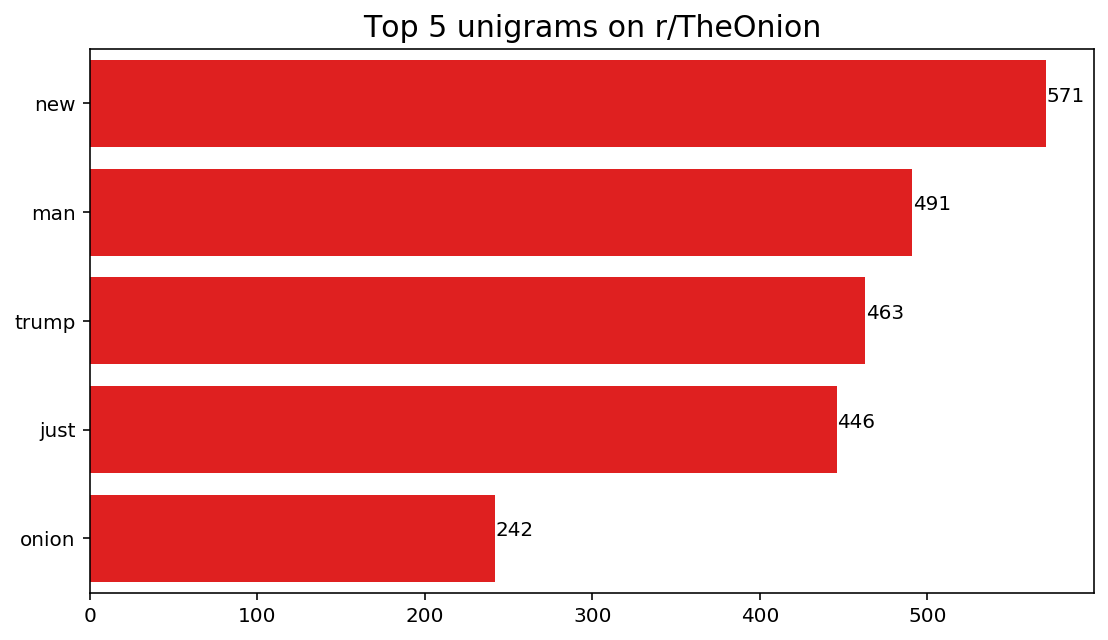

In [28]:
# Set up variables to contain top 5 most used words in Onion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 unigrams on r/TheOnion','r') 

### r/nottheonion: Top 5 Unigrams

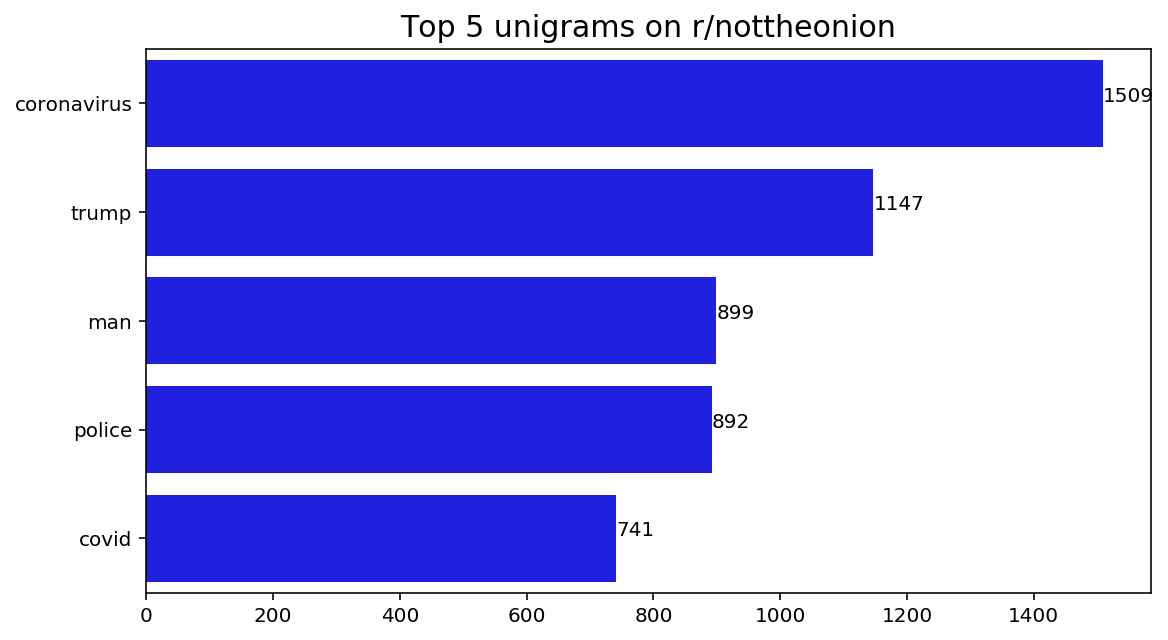

In [29]:
# Set up variables to contain top 5 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 unigrams on r/nottheonion','b') 

### Common Unigrams between Top 5 in r/TheOnion & r/nottheonion

In [30]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'man', 'trump'}

### Count Vectorize `df` where `subreddit` is `1`
 - `ngram_range = (2,2)`

In [31]:
# Set variables to show TheOnion Titles
mask = df['subreddit'] == 1
df_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
#onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                  # columns=cv.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec.shape)

(14007, 53592)


### Count Vectorize `df` where `subreddit` is `0`
 - `ngram_range = (2,2)`

In [32]:
# Set variables to show NotTheOnion Titles
mask = df['subreddit'] == 0
df_not_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11672, 58762)


In [63]:
not_onion_cvec_df

,aa team,abandoned animals,abandoned begs,abandoned cat,abandoned disney,abandoned ghost,abandoned puppies,abandoned warehouse,abandons master,abba kyari,...,zuckerberg dismisses,zuckerberg inaction,zuckerberg includes,zuckerberg initiative,zuckerberg says,zuckerberg security,zuckerberg served,zuckerberg test,zuckerberg thoughtfully,zuckerberg urges
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### r/TheOnion: Top 5 Bigrams

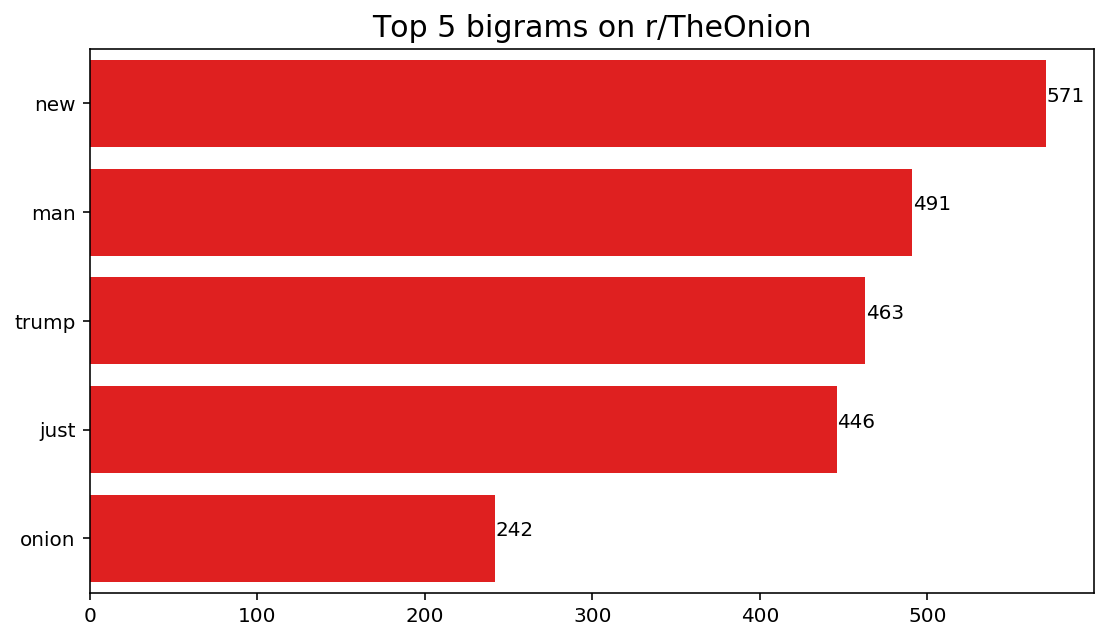

In [33]:
# Set up variables to contain top 5 most used bigrams in r/TheOnion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 bigrams on r/TheOnion','r') 

### r/nottheonion: Top 5 Bigrams

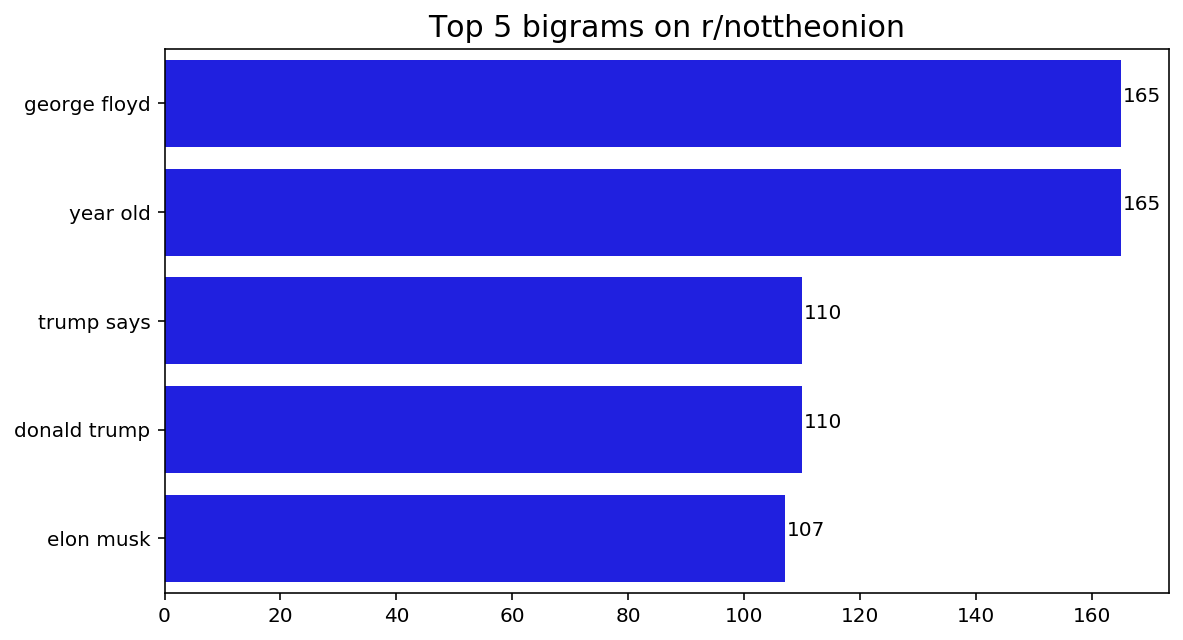

In [34]:
# Set up variables to contain top 5 most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 bigrams on r/nottheonion','b') 

### Common Bigrams between Top 5 in r/TheOnion & r/nottheonion

In [35]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

set()

Take out `{'man', 'new', 'old', 'people', 'say', 'trump', 'woman', 'year'}` from dataset when modeling, since these words occur frequently in both subreddits. 

### Create custom `stop_words` to include common frequent words

Referencing the common most-used words, add them to a customized `stop_words` list. 

In [36]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

# Modeling

Here I conduct model-prep and use Pipeline and GridSearch to determine the most optimal model to run my data on. 

### Baseline Score

In [37]:
# Baseline score
df['subreddit'].value_counts(normalize=True)

1    0.545465
0    0.454535
Name: subreddit, dtype: float64

I expect my model to be better than 54%. The majority class is `1`, or, `TheOnion`. If the model is not better than 54%, I know the model is not performing well.

### Set `X` (predictor) and `y` (target) variables 

In [38]:
X = df['title']
y = df['subreddit']

### Train/Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

### Model 1: CountVectorizer & Logistic Regression (Best Coefficient Interpretability)

In [40]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8486941170361909
Train score 0.9604340827664988
Test score 0.8624610591900311


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

Throughout my model testing, none of the stop_word lists were chosen as a best parameter. So from here on out, I omit them from my parameter selection. Additionally, while the model is overfit, I am optimizing to get the highest accuracy score in my test set. 

### Model 2: TfidfVectorize & Logistic Regression

In [41]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8464613946726206
Train score 0.9058621942987694
Test score 0.8565420560747663


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 5,
 'tvect__ngram_range': (1, 2)}

This model is also overfit. However, Model 1 performed with a better test score when comparing Logistic Regression models. 

### Model 3: CountVectorizer & MultinomialNB (Best Accuracy Score)

In [42]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8798483825743808
Train score 0.9945999273067138
Test score 0.8839563862928349


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.6}

The model is overfit, but as I mentioned, I am optimizing for accuracy. I want to ensure that all predictions are correct. That is, all posts from r/TheOnion must be classified as being from the subreddit r/TheOnion, and all posts from r/nottheonion must be classified as being from the subreddit r/nottheonion. This model gave me my best test accuracy score. 

### Model 4: TfidfVectorizer & MultinomialNB 

In [43]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8613115945791578
Train score 0.9187912144971182
Test score 0.8641744548286604


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}

This model is overfit. When comparing test scores of my MultinomialNB models, Model 3 performs better.

# Best Models 

In this section, I take my two optimal models and run them. The first model, CountVectorizer & MultinomialNB, will be used to convey a confusion matrix which will show all evaluation scores. The second model, CountVectorizer & Logistic Regression, will be used to interpret my coefficients.

### CountVectorizer & MultinomialNB: Best Score

In [44]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.8836448598130842


### Confusion Matrix

In [45]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2529,  389],
       [ 358, 3144]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

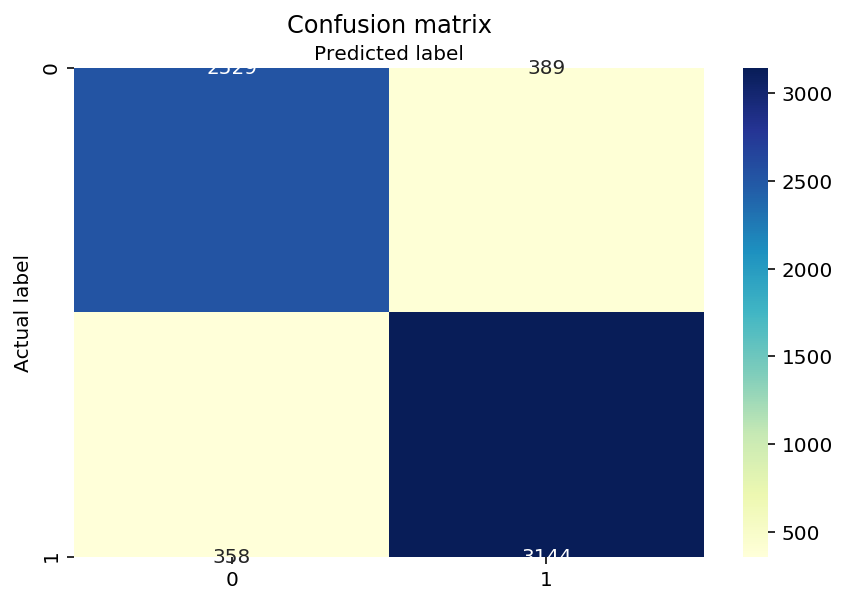

In [46]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=2)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [47]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [48]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 88.36 %
Precision: 88.99 %
Recall: 89.78 %
Specificity: 86.67 %
Misclassification Rate: 12.87 %


### CountVectorizer & Logistic Regression: Best Coefficient Interpretability

In [49]:
# Customize stop_words to include `onion` so that it doesn't appear
# in coefficients 

stop_words_onion = stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)
stop_words_onion.append('onion')

In [50]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = stop_words_onion)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.8559190031152648


### Coefficient Analysis

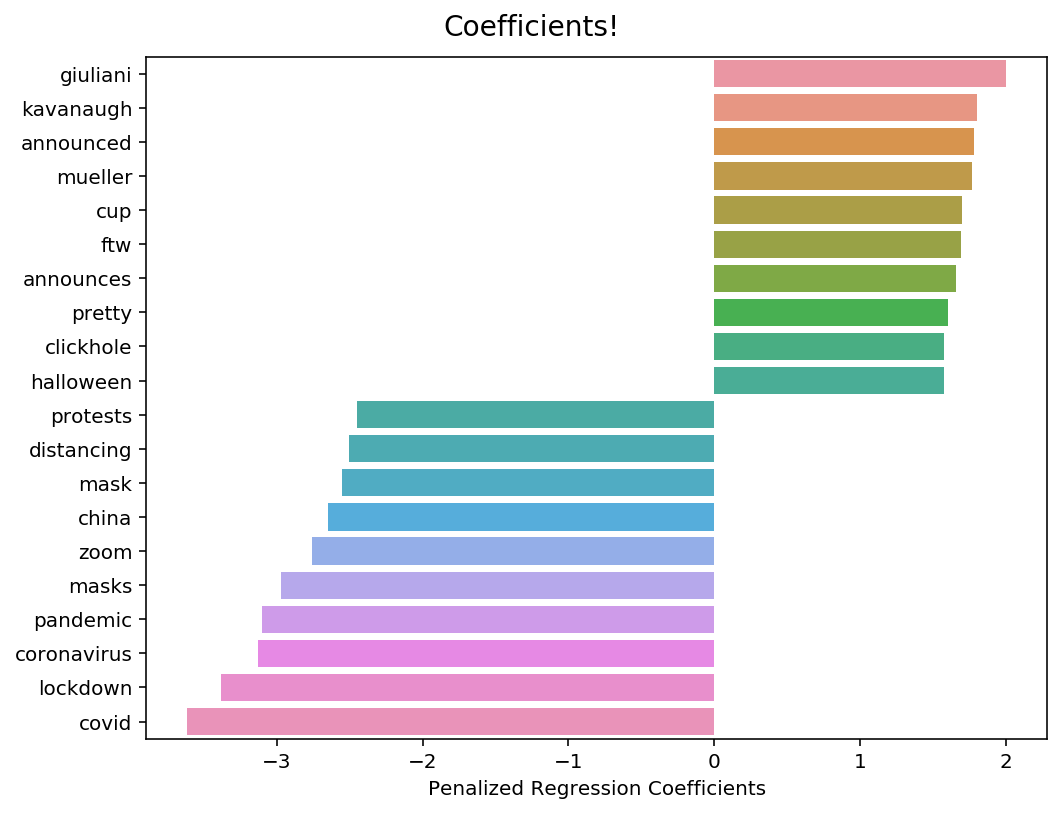

In [51]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [52]:
print("The word that contributes the most positively to being from r/TheOnion is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively to being from r/TheOnion is giuliani followed by kavanaugh and announced .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion is covid followed by lockdown and coronavirus .


In [53]:
# Show coefficients that affect r/TheOnion
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head1=df_merged_head.sort_values('exp', ascending=False)
df_merged_head1

,penalized_regression_coefficients,exp
giuliani,2.000,7.389056
kavanaugh,1.801,6.055700
announced,1.778,5.918009
mueller,1.765,5.841572
cup,1.697,5.457550
ftw,1.688,5.408653
announces,1.658,5.248803
pretty,1.602,4.962948
clickhole,1.572,4.816271
halloween,1.572,4.816271


In [54]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion.")

As occurences of giuliani increase by 1 in a title, that title is 7.39 times as likely to be classified as r/TheOnion.


In [55]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
covid,-3.614,37.114213
lockdown,-3.384,29.488489
coronavirus,-3.126,22.782666
pandemic,-3.104,22.286921
masks,-2.971,19.511421
zoom,-2.761,15.815651
china,-2.650,14.154039
mask,-2.554,12.858435
distancing,-2.505,12.243559
protests,-2.450,11.588347


In [56]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of covid increase by 1 in a title, that title is 37.11 times as likely to be classified as r/nottheonion.


# Conclusions and Next-Steps

The most model to optimize for accuracy in detecting fake news and absurd news uses CountVectorizer and MultinomialDB. The optimal parameters for this model are where `ngram_range` = (1,3) and `alpha` = 0.36. 
 - Accuracy: 89.72%
 - Precision: 90.87%
 - Recall: 90.02%
 - Specificity: 89.38%
 - Misclassification Rate: 11.11%

To interpret my coefficients, I used my CountVectorizer & Logistic Regression model. 
 - The word that contributes the most positively to being from r/TheOnion is 'incredible' followed by 'questions' and 'heartbreaking'.
   - As occurences of "incredible" increase by 1 in a title, that title is 10.32 times as likely to be classified as r/TheOnion.

- The word that contributes the most positively to being from r/nottheonion is 'australia' followed by 'title' and 'florida'.  
  - As occurences of "australia" increase by 1 in a title, that title is 15.03 times as likely to be classified as r/nottheonion.

Natural Language Processing of text is one way to analyze fake news, but a major gap exists: image & video analysis. For my next-steps, I am interested in being able to interpret media (images and videos) and classify them as authentic news, fake news, or none of the above (i.e., media for entertainment).